<h1 style="text-align: center;">Hit Analyzer</h1>
<h2 style="text-align: center;">By: Thomas Giewont, Shreyas Vaidya, and Thomas Varano</h2>

<br>
<h3 style="text-align: center;">Introduction</h3>
<p> This is the Introduction. </p>

<h3 style="text-align: center;">Imports and Data Setup</h3>

In [3]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

<h3 style="text-align: center;">Data Collection and Curation</h3>

In [4]:
df = pd.read_csv('https://query.data.world/s/aofqalvgkuabshmmlxm32rxk3t3yiq')

In [5]:
df = df.drop(columns=['url'])
df = df.rename(columns={'WeekID': 'week', 'Week Position': 'week_position', 'Song': 'song', 'Performer': 'performer', 'SongID': 'songid', 'Instance': 'instance', 'Previous Week Position': 'prev_week_position', 'Peak Position': 'peak_position', 'Weeks on Chart': 'weeks_on_chart'})

In [6]:
df = df.astype({"week": 'datetime64'})

In [7]:
# stuff after 2000
df = df[df.week > pd.to_datetime(datetime.date(2000, 1, 1))]


<h3 style="text-align: center;">Data Analysis</h3>

#### Hypothesis:
We believe that every song follows a similar trend when they reach the Billboard Top 100.

In [8]:
pks = {}

for s in df.songid.unique(): 
    # order by week, 
    pks[s] = min(df[df.songid == s].peak_position.unique())

df.peak = np.nan
for i, r in df.iterrows():
    df.at[i, 'peak'] = pks[r['songid']]


In [9]:
df = df.drop(columns=['peak_position'])
df = df[df.peak <= 10]

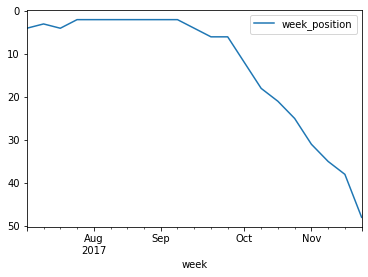

In [93]:
ax = plt.gca()
# for s in df.song.unique(): 
df[df.songid == 'Wild ThoughtsDJ Khaled Featuring Rihanna & Bryson Tiller'].plot(x='week', y='week_position', ax = ax)
plt.gca().invert_yaxis()
# print(min(pk))

In [94]:
# control points col
# (start, start_peak, end_peak, end)


In [95]:
# finding time before peak
# find when week_position == peak
# find the smallest weekid for my song
# subtract

# first hot week
# df.days_to_hot = np.nan

to_hot_dict = {}
time_hot_dict = {}
# df["inflections"] = 
# df["longest_peak"] = []
#full_inflection = {}
for s in df.songid.unique():
    # print(s)
    song_instances = df[df.songid == s].sort_values(by='week')
    
    if len(song_instances[song_instances.week_position <= 10].week) == 0: 
        to_hot_dict[s] = -1
        time_hot_dict[s] = -1
    else: 
        week = 1
        
        # get all peaks and their weeks
        # inflection points of graph in form: 
        # tuple (date, begin), where begin is true if the inflection point is beginning a hot spell
        inflections = []
        longest_peak = []
        for i in range(1, len(song_instances)): 
                
            if song_instances.iloc[i].week_position <= 10 and song_instances.iloc[i - 1].week_position > 10: 
                if i > 1 and song_instances.iloc[i-2].week_position <= 10: 
                    # remove the last ending guy
                        inflections.remove(inflections[len(inflections) - 1])
                else: 
                    inflections.append((song_instances.iloc[i].week, True))
            elif song_instances.iloc[i].week_position > 10 and song_instances.iloc[i - 1].week_position <= 10:
                inflections.append((song_instances.iloc[i - 1].week, False))
        #full_inflection[s] = inflections
        #TODO: DETERMINE CONDITIONAL FOR LONGEST PEAK, ALG NOT EXACT YET
        for i in range(0, len(inflections)-1):
            longest_date = datetime.timedelta(0)
            if len(inflections) == 0 or len(inflections) == 1:
                longest_peak = inflections
            else:
                # IMPROVE CONDITIONAL
                if inflections[i][1] is True and inflections[i+1][1] is False:
                    if inflections[i+1][0] - inflections[i][0] > longest_date:
                        longest_date = inflections[i+1][0] - inflections[i][0]
                        longest_peak = []
                        longest_peak.append(inflections[i])
                        longest_peak.append(inflections[i+1])
        print(s)
        print(longest_peak)         
            
#for i, r in df.iterrows(): 
 #   df.at[i, 'inflections'] = full_inflection[r.songid]
# df["inflections"] = full_inflection
        
        # find the longest peak

ainAdele
[(Timestamp('2012-01-07 00:00:00'), True), (Timestamp('2012-04-07 00:00:00'), False)]
RehabAmy Winehouse
[(Timestamp('2007-06-23 00:00:00'), True), (Timestamp('2007-07-14 00:00:00'), False)]
BubblyColbie Caillat
[(Timestamp('2007-10-06 00:00:00'), True), (Timestamp('2008-01-26 00:00:00'), False)]
Control MyselfLL Cool J Featuring Jennifer Lopez
[(Timestamp('2006-04-29 00:00:00'), True), (Timestamp('2006-05-06 00:00:00'), False)]
RadioactiveImagine Dragons
[(Timestamp('2013-05-11 00:00:00'), True), (Timestamp('2013-09-14 00:00:00'), False)]
Break It OffRihanna & Sean Paul
[(Timestamp('2007-03-10 00:00:00'), True), (Timestamp('2007-03-17 00:00:00'), False)]
ApologizeTimbaland Featuring OneRepublic
[(Timestamp('2007-10-13 00:00:00'), True), (Timestamp('2008-03-29 00:00:00'), False)]
Sweet NothingCalvin Harris Featuring Florence Welch
[]
BlowKe$ha
[(Timestamp('2011-05-07 00:00:00'), True), (Timestamp('2011-05-14 00:00:00'), False)]
Can't Hold UsMacklemore & Ryan Lewis Featuring Ra

In [96]:
inflections = []
        for i in range(1, len(all_hot_weeks)): 
            if all_hot_weeks[i] != all_hot_weeks[i-1] + timedelta(days=7): 
                # I am the beginning, the guy before me is an end.
                inflections.append((all_hot_weeks[i], True))
                inflections.append((all_hot_weeks[i-1], False))
#             elif all_hot_weeks[i] != all_hot_weeks[i+1] - timedelta(days=7): 
#                 inflections.append(all_hot_weeks[i])
#         inflections.append(all_hot_weeks[len(all_hot_weeks) - 1])
        print(f'{s}: {inflections}')

IndentationError: unexpected indent (<ipython-input-96-dd68b88363ce>, line 2)

In [ ]:
first_hot_week = min(song_instances[song_instances.week_position <= 10].week)
        first_week = min(df[df.songid == s].week)
        
#         last_hot_week = 
#         last_week = 
        to_hot_dict[s] = (first_hot_week - first_week).days/7
        temp = df[df.songid == s]
        time = first_hot_week + timedelta(days=7)
       
        # while i am in the top 10
            # NOTE take the longest peak with grace period
        while temp[temp.week == time].week_position.size > 0 and temp[temp.week == time].week_position.values >= 10:
            week += 1
            time += timedelta(days=7)
            
        time_hot_dict[s] = week

for i, r in df.iterrows(): 
    df.at[i, 'weeks_to_hot'] = to_hot_dict[r['songid']]
    df.at[i, 'weeks_hot'] = time_hot_dict[r['songid']]
df

In [ ]:
# df.hist(column='weeks_to_hot')
# df.weeks_to_hot.unique()
# NOTE: "All I Want for Christmas" by Mariah Carey had multiple times in many years peak. This is an outlier.
df[df.weeks_to_hot <= 52].hist(column='weeks_to_hot')

In [ ]:
df[df.weeks_hot <= 25].hist(column='weeks_hot')

<h3 style="text-align: center;">Insights Attained</h3>